In [1]:
import json
import re
import string
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator

In [2]:
filename = "./jsons/imagine_dragons.json"
with open(filename) as json_file:
    data = json.load(json_file)

lyrics = [song["lyrics"] for song in data]
all_lyrics = " ".join(lyrics)

In [3]:
print(all_lyrics[:300])

First things first I'ma say all the words inside my head I'm fired up and tired of the way That things have been, oh-ooh The way that things have been, oh-ooh Second things second Don't you tell me what you think that I could be I'm the one at the sail, I'm the master of my sea, oh-ooh The master of


# 1. Cleaning text

In [35]:
# Copy original lyrics to another variable
lyrics = all_lyrics[:]

## 1.1 Remove extra spaces

In [36]:
# Remove extra spaces
lyrics = re.sub(" +", " ", lyrics)
lyrics[:300]

"First things first I'ma say all the words inside my head I'm fired up and tired of the way That things have been, oh-ooh The way that things have been, oh-ooh Second things second Don't you tell me what you think that I could be I'm the one at the sail, I'm the master of my sea, oh-ooh The master of"

## 1.2 Removing punctuations

In [37]:
lyrics = "".join([i for i in lyrics if i not in string.punctuation])
lyrics_regex = re.sub("[^a-zA-Z]", " ", lyrics) # Another way

print(lyrics[:300])
assert lyrics[:300] == lyrics_regex[:300]

First things first Ima say all the words inside my head Im fired up and tired of the way That things have been ohooh The way that things have been ohooh Second things second Dont you tell me what you think that I could be Im the one at the sail Im the master of my sea ohooh The master of my sea ohoo


## 1.3 Case normalization

In [38]:
lyrics = "".join([i.lower() for i in lyrics])
print(lyrics[:300])

first things first ima say all the words inside my head im fired up and tired of the way that things have been ohooh the way that things have been ohooh second things second dont you tell me what you think that i could be im the one at the sail im the master of my sea ohooh the master of my sea ohoo


## 1.4 Removing Stopwords

In [40]:
stopwords = nltk.corpus.stopwords.words("english")
lyrics = " ".join([i for i in lyrics.split() if i not in stopwords])
print(lyrics[:300])

first things first ima say words inside head im fired tired way things ohooh way things ohooh second things second dont tell think could im one sail im master sea ohooh master sea ohooh broken young age taking sulking masses writing poems look took shook feeling singing heartache pain taking message


## 1.5 Comparing original lyrics with cleaned

In [45]:
print(
f"""Original lyrics:
{all_lyrics[:300]}

Cleaned lyrics:
{lyrics[:300]}""")

Original lyrics:
First things first I'ma say all the words inside my head I'm fired up and tired of the way That things have been, oh-ooh The way that things have been, oh-ooh Second things second Don't you tell me what you think that I could be I'm the one at the sail, I'm the master of my sea, oh-ooh The master of

Cleaned lyrics:
first things first ima say words inside head im fired tired way things ohooh way things ohooh second things second dont tell think could im one sail im master sea ohooh master sea ohooh broken young age taking sulking masses writing poems look took shook feeling singing heartache pain taking message


# 2. Creating a DataFrame and cleaning it

In [9]:
filename = "./jsons/imagine_dragons.json"

df = pd.read_json(filename)
df = df[["name", "url", "lyrics"]]

In [10]:
df.head()

,name,url,lyrics
0,Believer,https://www.letras.com/imagine-dragons/believer/,First things first I'ma say all the words insi...
1,Demons,https://www.letras.com/imagine-dragons/demons/,When the days are cold And the cards all fold ...
2,Bones,https://www.letras.com/imagine-dragons/bones/,"Gimme, gimme, gimme some time to think I'm in ..."
3,Bad Liar,https://www.letras.com/imagine-dragons/bad-liar/,"Oh hush, my dear, it's been a difficult year A..."
4,Not Today,https://www.letras.com/imagine-dragons/not-today/,There she goes in front of me Take my life and...


In [46]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from unicodedata import normalize

def clean_data(df, col, clean_col, language="english"):
    stop_words = set(stopwords.words(language))

    df[clean_col] = df[col].apply(lambda x: re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", x), 0, re.I
    ))

    # Change to lower and remove spaces on either side
    df[clean_col] = df[clean_col].apply(lambda x: x.lower().strip())

    # Remove extra spaces in between
    df[clean_col] = df[clean_col].apply(lambda x: re.sub(" +", " ", x))

    # Remove punctuation
    df[clean_col] = df[clean_col].apply(lambda x: re.sub("[^a-zA-Z]", " ", x))

    # Remove stopwords
    df[clean_col] = df[clean_col].apply(lambda x: " ".join(text for text in x.split() if text not in stop_words))
    
    return df

In [47]:
df = clean_data(df, "lyrics", "clean_lyrics")

In [48]:
df.head()

,name,url,lyrics,clean_lyrics
0,Believer,https://www.letras.com/imagine-dragons/believer/,First things first I'ma say all the words insi...,first things first say words inside head fired...
1,Demons,https://www.letras.com/imagine-dragons/demons/,When the days are cold And the cards all fold ...,days cold cards fold saints see made gold drea...
2,Bones,https://www.letras.com/imagine-dragons/bones/,"Gimme, gimme, gimme some time to think I'm in ...",gimme gimme gimme time think bathroom looking ...
3,Bad Liar,https://www.letras.com/imagine-dragons/bad-liar/,"Oh hush, my dear, it's been a difficult year A...",oh hush dear difficult year terrors prey innoc...
4,Not Today,https://www.letras.com/imagine-dragons/not-today/,There she goes in front of me Take my life and...,goes front take life set free make memory holy...


# 3. Defining function to generate a Word Cloud using lyrics

In [49]:
def create_wordcloud(text, width=1920, height=1080):
    wordcloud = WordCloud(width=width, height=height).generate_from_frequencies(text)
    return wordcloud

In [50]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [51]:
from nltk.corpus import stopwords
from unicodedata import normalize

import scrap

def clean_lyrics(text, language="english"):
    stop_words = set(stopwords.words(language) + ["si", "mas"])

    clean_text =  re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize( "NFD", text), 0, re.I
    )

    # Change to lower and remove spaces on either side
    clean_text = clean_text.lower().strip()

    # Remove extra spaces in between
    clean_text = re.sub(" +", " ", clean_text)

    # Remove punctuation
    clean_text = re.sub("[^a-zA-Z]", " ", clean_text)

    # Remove stopwords
    clean_text = " ".join(t for t in clean_text.split() if t not in stop_words)
    
    return clean_text

def song_wordcloud(song_url, language="english", plot=True):
    song_lyrics = scrap.get_lyrics_from_url(song_url, True)
    cleaned = clean_lyrics(song_lyrics, language)
    count = word_count(cleaned)
    song_wordcloud = create_wordcloud(count)

    if plot:
        plt.figure(figsize=(15,10))
        plt.imshow(song_wordcloud)
        plt.axis("off")
        plt.show()

    return song_wordcloud

def artist_wordcloud(artist_url, language="english", plot=True):

    songs = scrap.get_songs_list(artist_url)

    cleaned_lyrics = []

    for song in songs:
        # print(song)
        song_lyrics = scrap.get_lyrics_from_url(song, True)
        cleaned = clean_lyrics(song_lyrics, language)
        cleaned_lyrics.append(cleaned)

    cleaned_lyrics = " ".join(cleaned_lyrics)
    count = word_count(cleaned_lyrics)
    song_wordcloud = create_wordcloud(count)

    # print(cleaned_lyrics)

    if plot:
        plt.figure(figsize=(15,10))
        plt.imshow(song_wordcloud)
        plt.axis("off")
        plt.show()

    return song_wordcloud

# 4. Generating Word Clouds with artists songs

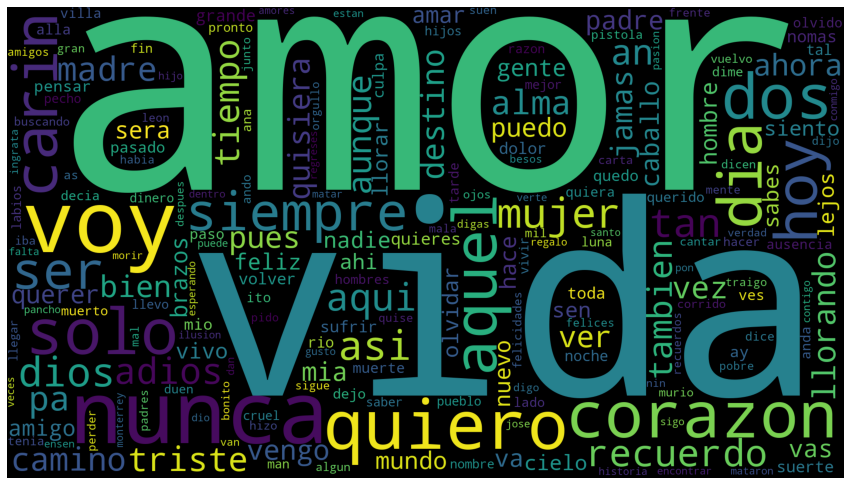

In [52]:
artist_wordcloud("https://www.letras.com/cadetes-de-linares/", "spanish")

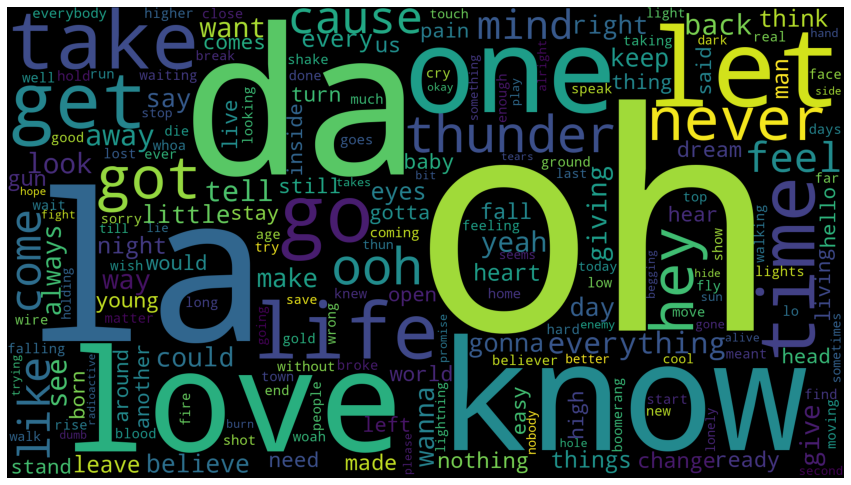

In [53]:
artist_wordcloud("https://www.letras.com/imagine-dragons/")

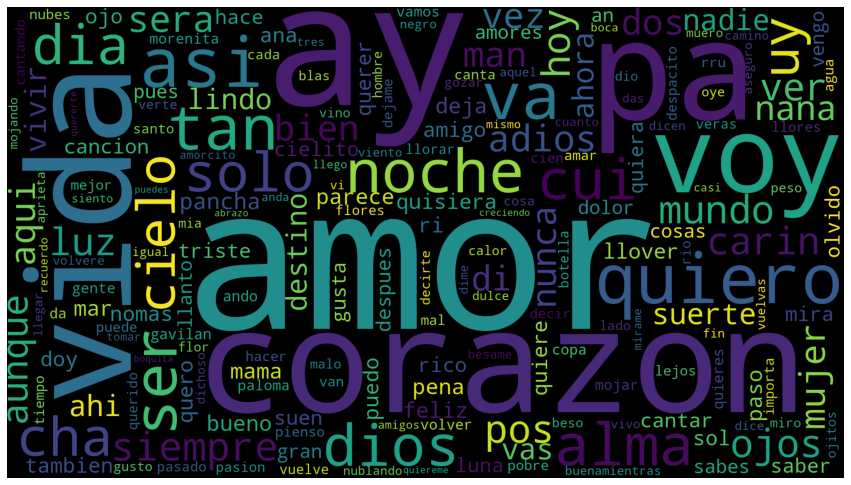

In [54]:
artist_wordcloud("https://www.letras.com/pedro-infante/", "spanish")

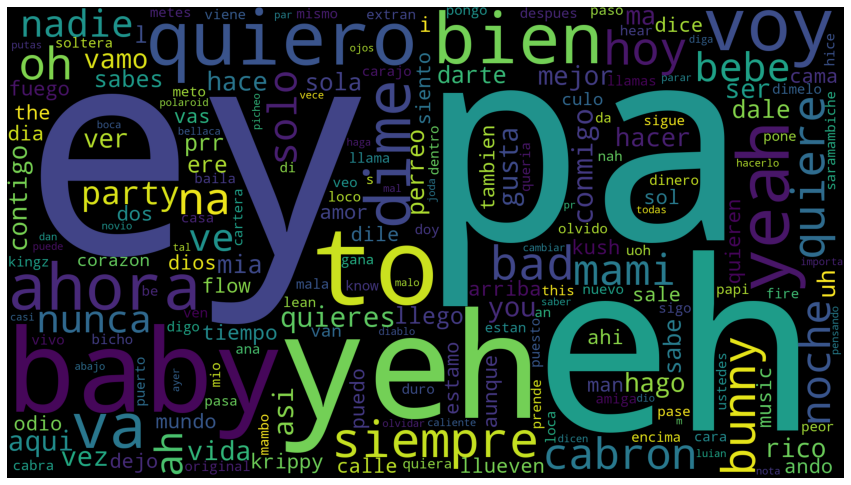

In [55]:
artist_wordcloud("https://www.letras.com/bad-bunny/", "spanish")

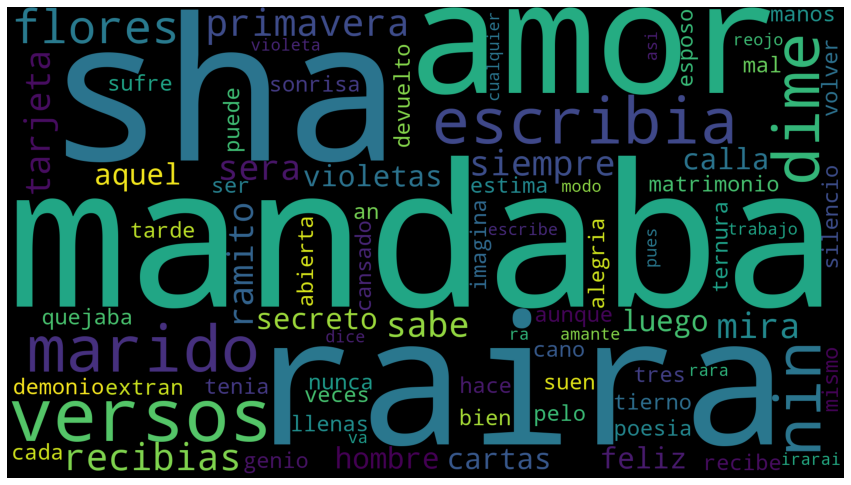

In [57]:
song_wordcloud("https://www.letras.com/mi-banda-el-mexicano/839291/", "spanish")